<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/06_divergent_transitions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. サンプリングが上手くいかない場合の例
* 密度関数が非常にpeakyであるとき、サンプリングが上手くいかないことがある。
 * peakyになっている部分が、サンプリングによって全くカバーされなかったりする。
* この場合、reparameterizationを使うと、問題が解決することがある。
 * https://mc-stan.org/docs/2_26/stan-users-guide/reparameterization-section.html

## 6.0 準備

In [1]:
!pip install arviz==0.10
!pip install pymc3==3.10

     |████████████████████████████████| 1.5MB 7.7MB/s 
     |████████████████████████████████| 4.7MB 29.7MB/s 
     |████████████████████████████████| 768kB 43.9MB/s 
     |████████████████████████████████| 317kB 44.2MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
     |████████████████████████████████| 1.9MB 8.2MB/s 
     |████████████████████████████████| 2.8MB 26.8MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.0.11-cp37-none-any.whl size=2572023 sha256=b189cf142e3eaf45dfbe065439f83cb10b74248a4c41ab1795ccafb19e315f1e
  Stored in directory: /root/.cache/pip/wheels/26/b2/77/4ee2bb9b1c1de7de771254a5e379d898273d8114237b0df686
Successfully built theano-pymc
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = 20210328

## 6.1 サンプリングがうまく行かない理由
* 詳細は割愛。
 * https://mc-stan.org/docs/2_26/reference-manual/divergent-transitions.html
 * ざっくり言うと・・・HMCは、勾配を使ってfirst-orderの近似を行っているため、"地形が急峻な"場所では、本当に求めたいものから大きく外れてしまうことがある。すると、サンプリングがパラメータ空間内での単なるランダムウォークに近くなってしまい、密度関数の"濃淡"を反映しないものになってしまう。
 * ここも参照→ https://norimune.net/3149

## 6.2 モデル
* 下のような確率分布を考える。
$$\begin{align} 
y & \sim N(0, 3^2) \\
x_i & \sim N(0, e^y), \text{ $i=1,\ldots, 9$ }  
\end{align}$$


* 同時分布を式で書くと・・・
$$p(y, x_1, \ldots, x_9) = p(y) \prod_{i=1}^9 p(x_i | y)$$
where
$$ p(y) = \frac{1}{\sqrt{2\pi 3^2}} \exp\bigg( - \frac{y^2}{2 \times 3^2}\bigg)  $$
and
$$ p(x_i | y) = \frac{1}{\sqrt{2\pi e^y}} \exp\bigg( - \frac{x_i^2}{2e^y} \bigg) $$

* このモデルの問題点
 * $y$の値が小さいとき、$x_i$が従う正規分布が非常にpeakyな密度関数を持つことになり、サンプリングが困難になる。

* 今回は、この分布によって生成されたと仮定する観測データを用意して$y$の事後分布を求めるのではなく・・・
* この分布から直接サンプルを取る。（つまり、この分布に従う乱数を発生させる。）

## 6.3 実装方法 (1)
* これは悪い実装方法。
 * divergent transitionが発生する。
 * さらに、周辺分布$p(y)$は正規分布となるはずなのに、ヒストグラムが全く正規分布の形にならない。

In [ ]:
with pm.Model() as model:
  y = pm.Normal("y", mu=0, sd=3)
  x = pm.Normal("x", mu=0, sd=(y/2).exp(), shape=9)

In [ ]:
with model:
    trace = pm.sample(2000, cores=4, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6229251102014379, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6600310224029062, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
x0 = trace['x'][:,0]

In [ ]:
x0.shape

(8000,)

In [ ]:
y = trace['y']

In [ ]:
y.shape

(8000,)

In [ ]:
divergent = trace['diverging']

In [ ]:
divergent.shape

(8000,)

In [ ]:
(divergent == 1).sum()

13

Text(0.5, 1.0, 'scatter plot between y and x[0]')

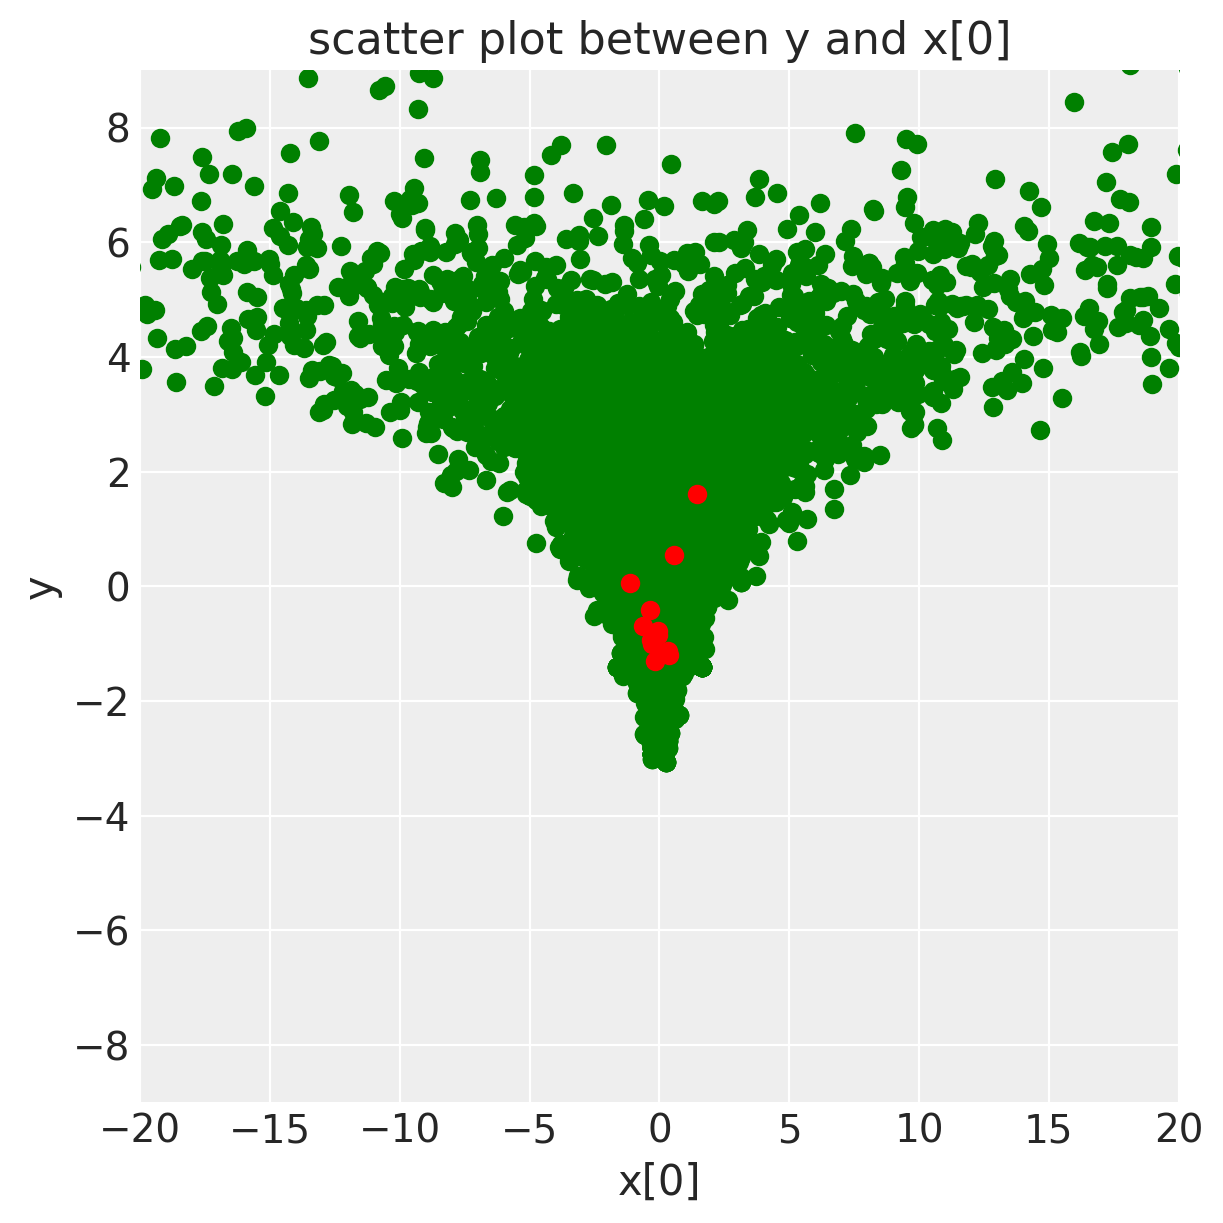

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(x0[divergent == 0], y[divergent == 0], color='g')
plt.scatter(x0[divergent == 1], y[divergent == 1], color='r')
plt.axis([-20, 20, -9, 9])
plt.ylabel('y')
plt.xlabel('x[0]')
plt.title('scatter plot between y and x[0]')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


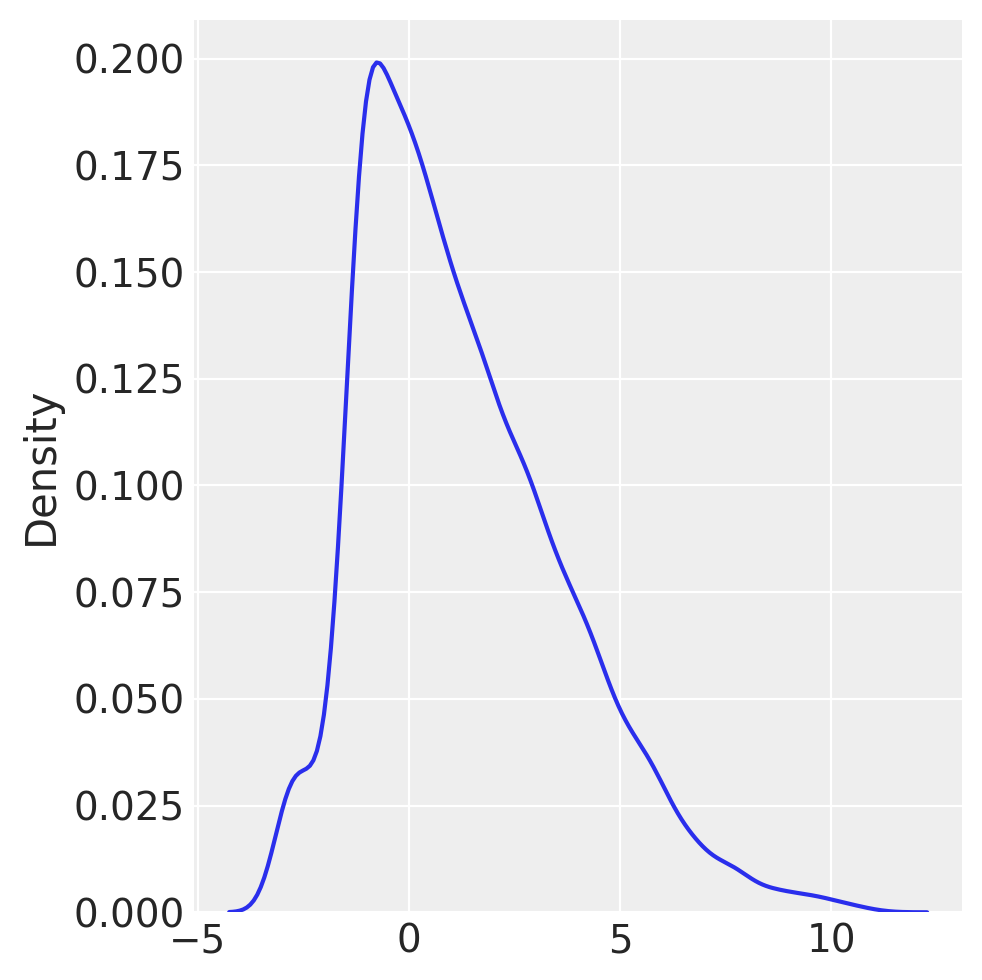

In [ ]:
sns.displot(y, kind="kde")

## 6.4 実装方法 (2)
* これは、reparameterizationを使うことで改良された実装。
 * divergent transitionは起こらない。
 * $y$のサンプルのヒストグラムも正規分布の形を示す。

In [ ]:
with pm.Model() as model_revised:
  y = pm.Normal("y", mu=0, sd=3)
  x_raw = pm.Normal("x_raw", mu=0, sd=1, shape=9)
  x = pm.Deterministic("x", (y/2).exp() * x_raw)

In [ ]:
with model_revised:
    trace_revised = pm.sample(2000, cores=4, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_raw, y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


In [ ]:
x0 = trace_revised['x'][:, 0]
y = trace_revised['y']
divergent = trace_revised['diverging']

Text(0.5, 1.0, 'scatter plot between y and x[0]')

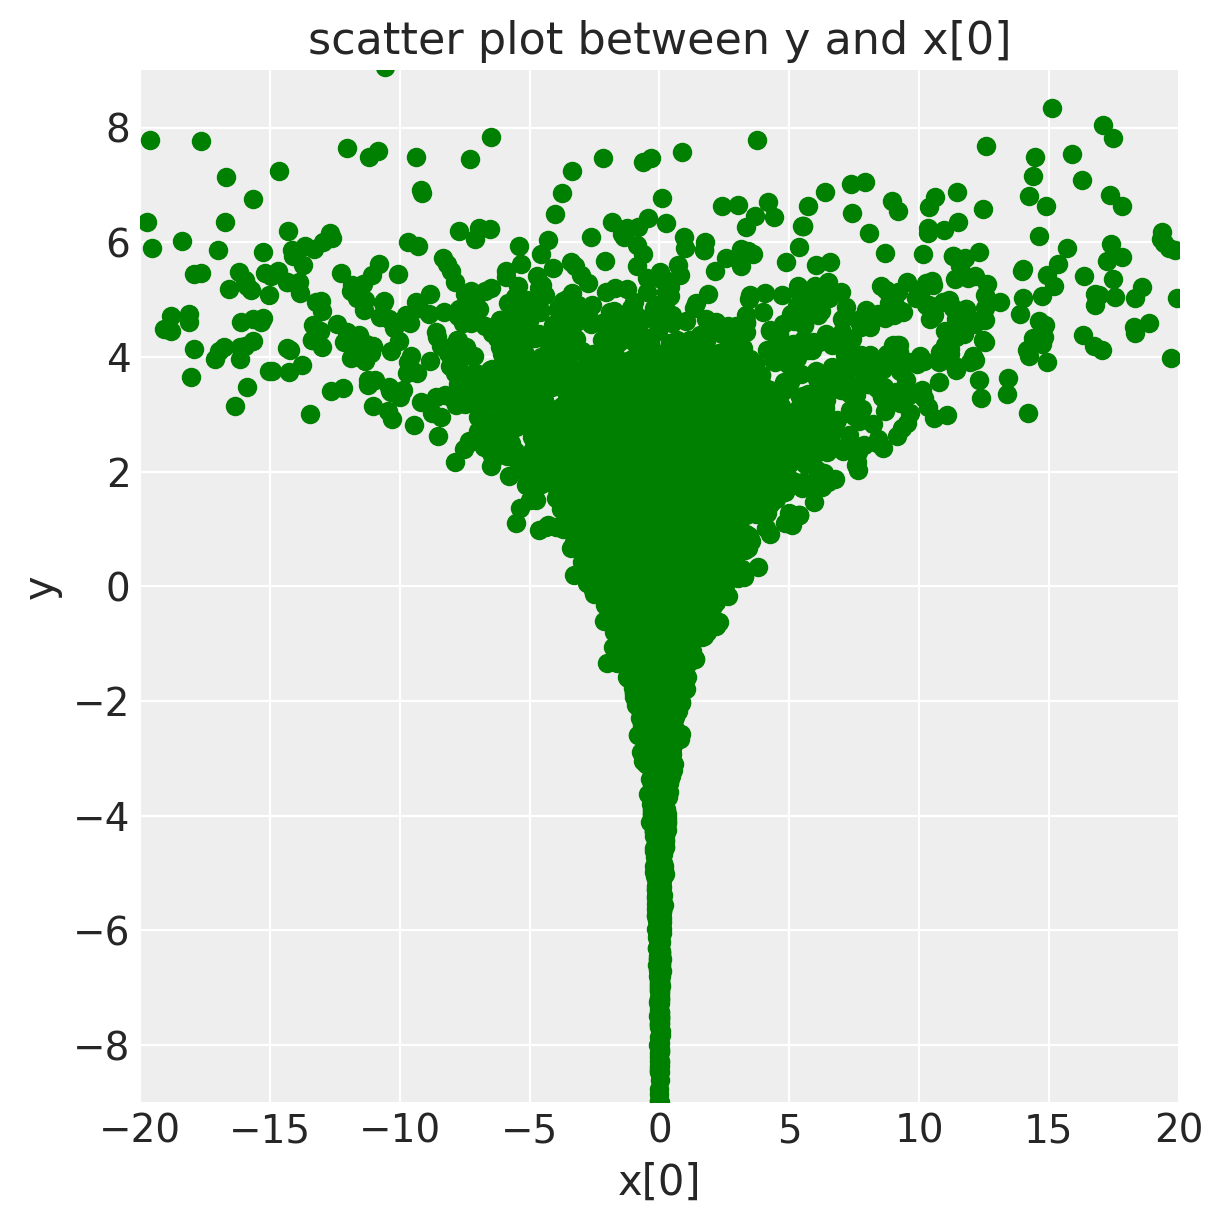

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(x0[divergent == 0], y[divergent == 0], color='g')
plt.scatter(x0[divergent == 1], y[divergent == 1], color='r')
plt.axis([-20, 20, -9, 9])
plt.ylabel('y')
plt.xlabel('x[0]')
plt.title('scatter plot between y and x[0]')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


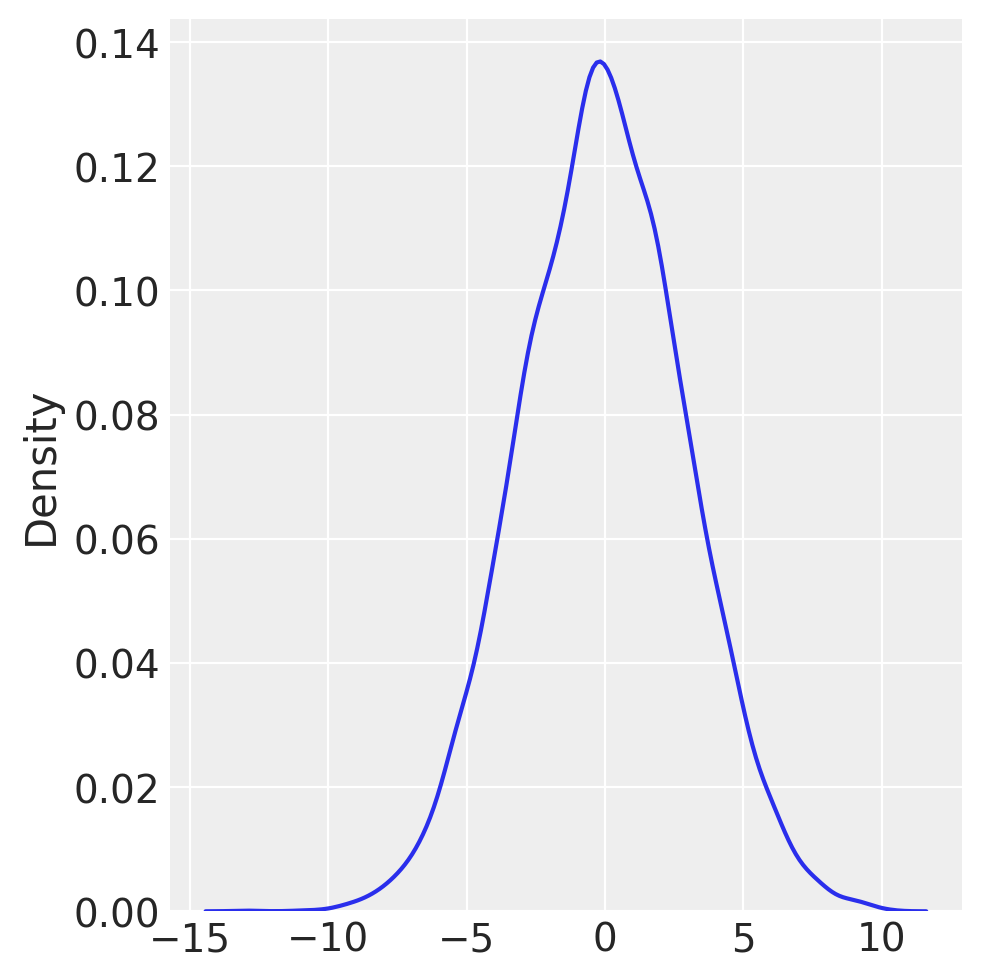

In [ ]:
sns.displot(y, kind="kde")

## 6.5 考察
* なぜ上のようなことが起こるのか。
* HMCが、そこからのサンプリングを不得意とする密度関数とは、どのようなものだろうか。
* 下記の資料をもとにして、この点について考えてみる。
 * https://mc-stan.org/docs/2_26/reference-manual/hmc-chapter.html

## 課題6
* 下記のWebページにある実験を再現してみよう。
 * https://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html